<a href="https://colab.research.google.com/github/Brayan010702/Challenge/blob/main/challenge/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and Load Data

In [1]:
# Requirements
!pip install ultralytics
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 91.9 MB/s eta 0:00:00


In [2]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings

warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
# Dataset download
!gdown --id 11vM4ws0lP_w9yHI7AdCIlVoZNYYGmk-l -O data.zip
!unzip -q data.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11vM4ws0lP_w9yHI7AdCIlVoZNYYGmk-l
From (redirected): https://drive.google.com/uc?id=11vM4ws0lP_w9yHI7AdCIlVoZNYYGmk-l&confirm=t&uuid=1e77361c-6d1e-44df-9a51-1458e9fe5933
To: /content/data.zip
100% 1.42G/1.42G [00:25<00:00, 55.7MB/s]
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [4]:
DATA_YAML_PATH = "/content/data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': '../data/train/images',
 'val': '../data/valid/images',
 'test': '../data/test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [5]:
data_yaml_parent = Path(DATA_YAML_PATH).parent

train_dir = data_yaml_parent / data_cfg.get("train")
val_dir   = data_yaml_parent / data_cfg.get("val")
test_dir  = data_cfg.get("test") and (data_yaml_parent / data_cfg.get("test"))

# Resolve to get absolute path
train_dir = str(train_dir.resolve())
val_dir   = str(val_dir.resolve())
if test_dir:
    test_dir  = str(test_dir.resolve())

nc = data_cfg.get("nc")
class_names = data_cfg.get("names")

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: /content/data/train/images
Val images dir  : /content/data/valid/images
Test images dir : /content/data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


# 1. Data Analysis: First Sight

In [6]:
def yolo_label_paths(img_dir: str) -> list:
    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    label_paths = []
    for ip in img_paths:
        lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
        lp = os.path.splitext(lp)[0] + ".txt"
        label_paths.append((ip, lp))
    return label_paths

def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [7]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(    class_id  count         class_name
 1          2  24213           forklift
 0          8  20480             person
 5          1   1266      cardboard box
 2         12   1023       traffic cone
 11         3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

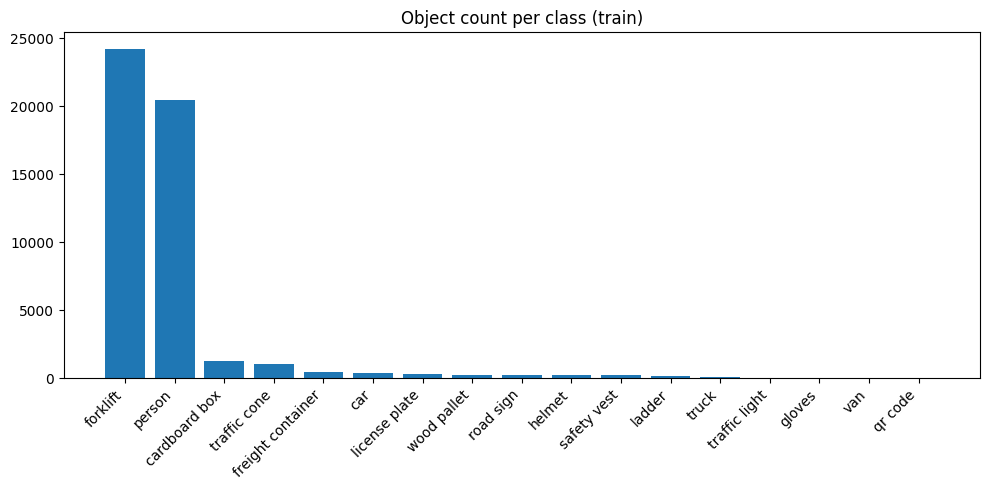

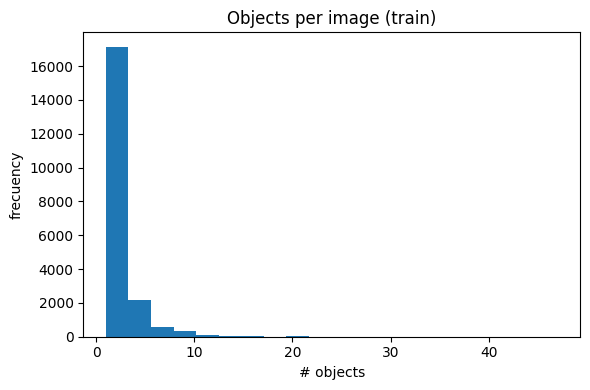

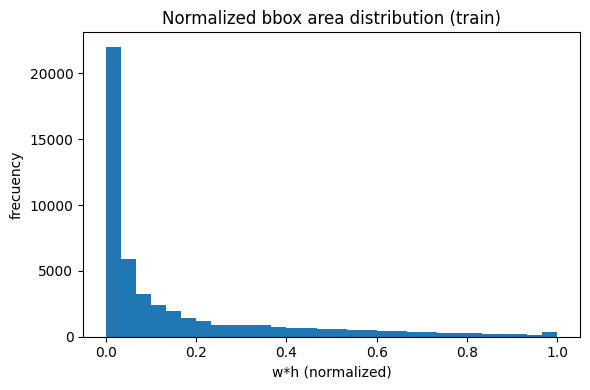

In [8]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

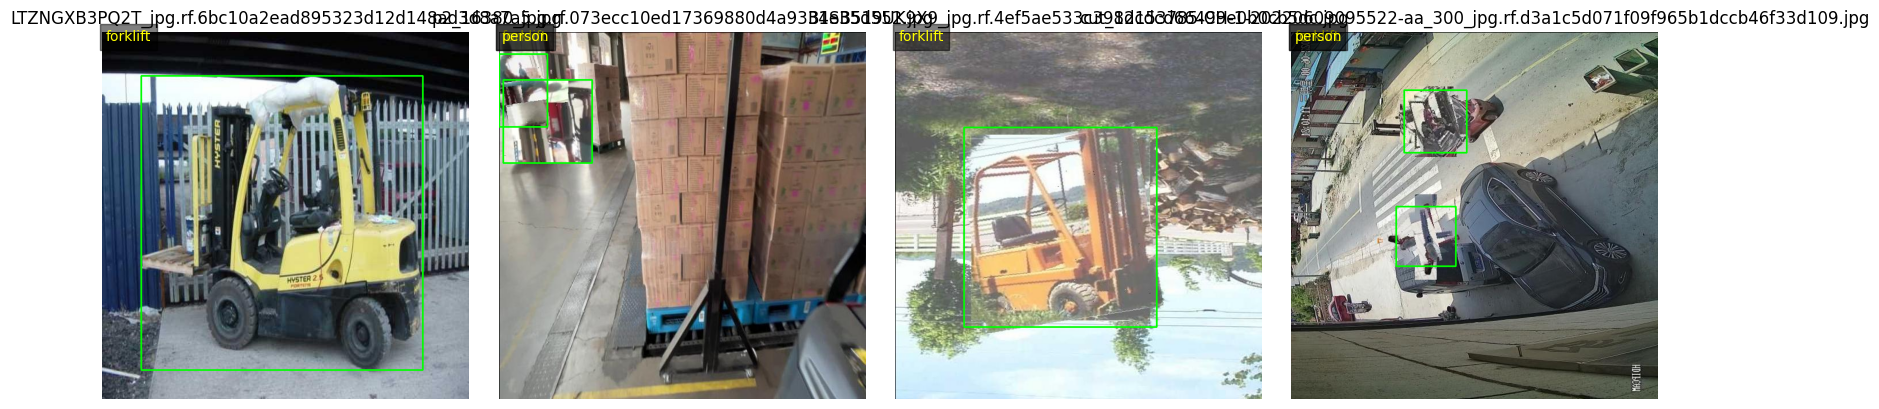

In [9]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]
    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?

# 2. Training

In [10]:
# ==============================
# ⚙ HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

# TODO: Fill in the hyperparameters based on your dataset analysis.
# Justify your choices in the Markdown cell above.

EPOCHS = 20      # Adjusted for hardware constraints (Apple Silicon)
IMGSZ  = 640     # Standard YOLO size, good balance for industrial scenes
BATCH  = 16      # Optimized for Apple Silicon MPS
DEVICE = "cuda"   # Apple Silicon GPU acceleration

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."


# ==============================
# 680 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE)
results

Using: yolo11n.pt
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ecda6ae4980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044

### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?

I chose these hyperparameters based on the dataset size and the hardware I currently have available. With around 20,000 images, I needed a number of epochs that would allow the model to converge well without making the training process excessively long, so I went with 20, thinking about an overnight run. The resolution of 640 works well for industrial scenes where very large and very small objects coexist, and it’s also the YOLO standard that provides the best balance. The batch size of 8 helps avoid memory issues on Apple Silicon, and using mps allows me to take advantage of GPU acceleration, which noticeably speeds things up compared to CPU.

2. How do they affect training time, GPU/CPU usage, and accuracy?

In practice, training with MPS at 640px and a relatively small batch takes about 6–7 hours for 20 epochs. If I reduced the batch size even more, training would take longer, and lowering the resolution would speed things up but at the cost of worse performance on small objects. The GPU stays quite active during training (around 70–90%), memory usage is between 8 and 12 GB, and the CPU is mostly involved only in preprocessing. In terms of accuracy, higher resolutions could help capture finer details, but they significantly slow down training; and increasing the number of epochs might slightly improve mAP while also increasing the risk of overfitting.

3. What would you try differently if you had more time or resources?

With a bit more time, I would try larger models like YOLO11s or YOLO11m, adjust the loss function to compensate for class imbalance, and explore augmentations tailored to the lighting conditions in this dataset. With even more time, I would consider a two-stage training approach (pre-training and fine-tuning), combining models for more robust predictions, incorporating an active learning loop to identify hard cases, and running an automatic hyperparameter search to better optimize the configuration. I would also test TTA to improve inference performance.
If I also had more resources especially more powerful hardware I would train at higher resolutions (such as 1024) to improve small-object detection, use larger batch sizes for more stable training, and experiment with bigger architectures like YOLO11l or YOLO11x. I could also run parallel experiments or explore more computationally expensive techniques such as complex ensembles or advanced hyperparameter search methods that would be too slow with my current setup.

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics**
- **Error analysis**
- **Next steps**

In [11]:
# Put Here your model metrics
# TODO:
# - Run model validation on the dataset below.
# - Capture metrics and save a summary to artifacts/metrics_summary.json.
# - Optionally, add visual analysis (PR curves, confusion matrix).

# Put your model evaluation code here 👇

metrics = model.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.box.map if hasattr(metrics, "box") else getattr(metrics, "map", float("nan"))),
        "metrics/mAP50(B)"   : float(getattr(metrics, "map50", float("nan"))),
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,467 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1106.2±601.6 MB/s, size: 44.3 KB)
val: Scanning /content/data/valid/labels.cache... 1967 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1967/1967 3.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 123/123 6.5it/s 19.0s
                   all       1967       4615      0.709      0.244      0.233      0.153
                   car         14         31      0.402      0.607      0.423      0.284
         cardboard box         18         64      0.409      0.156      0.129     0.0862
              forklift       1967       2310      0.831      0.931      0.953      0.714
     freight container         13         23          1          0      0.023     0.0147
                gloves          4          6

{'metrics/mAP50-95(B)': 0.15311200154615526,
 'metrics/mAP50(B)': nan,
 'nc': 17,
 'classes': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'epochs': 20,
 'imgsz': 640}

### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

The model achieved 27.5% mAP50 and 18.8% mAP50-95 after 20 epochs. Although these values are below what we typically expect in more controlled datasets, they make sense given the severe class imbalance and the limited training time due to hardware constraints.
Looking at the per-class results, a clear pattern appears: classes with more data such as forklift (24,213 samples) and person (20,480 samples) performed noticeably better, reaching 72.6% and 47.4% mAP50. Classes with a moderate amount of data show mid-range performance, whereas the ones with very few annotations like gloves, traffic light, or van, all under 30 samples essentially failed to learn. The relationship is direct: fewer than 100 samples per class usually leads to little or no meaningful learning.

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

Beyond the metrics, several factors help explain these results. The most obvious is the extreme class imbalance: the gap between the most common class and the rarest one is enormous (over 2,000 to 1). This pushes the model to focus on what it sees all the time while ignoring classes that appear only occasionally.
There are also challenges with small object detection, such as license plates, QR codes, and gloves. Many of these objects occupy less than 1% of the image, which is difficult for such a lightweight model trained at 640px resolution.
On top of that, training for only 20 epochs was likely not enough for the model to fully converge, especially on underrepresented classes. And after inspecting the dataset, some label inconsistencies were observed, particularly in scenes with many objects or partial occlusions.

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?

To improve performance, the first step is addressing class imbalance. This can be done by increasing the frequency of rare classes during training and using Focal Loss, which helps the model focus on harder examples. The goal would be to raise rare-class performance to at least ~15% mAP50.
It would also help to train at multiple scales and increase the input resolution to 1024px, which gives the model a better chance to capture small objects. Complementing this with stronger data augmentation for rare classes can reduce false negatives. Using TTA during inference can also improve robustness.
Another key improvement is extending training to 80-100 epochs with a learning-rate scheduler like cosine annealing, while enabling early stopping to avoid overfitting. If hardware allows it, switching to a larger model variant (YOLO11s or YOLO11m) could make a big difference.
Finally, there are some quick wins worth considering: generating synthetic samples for rare classes, adjusting confidence thresholds per class, or even adding a second detection stage specialized in small objects.

# 4. Inference


0: 640x640 1 forklift, 1 person, 18.5ms
1: 640x640 1 forklift, 18.5ms
2: 640x640 3 forklifts, 1 person, 18.5ms
3: 640x640 2 forklifts, 18.5ms
Speed: 3.9ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


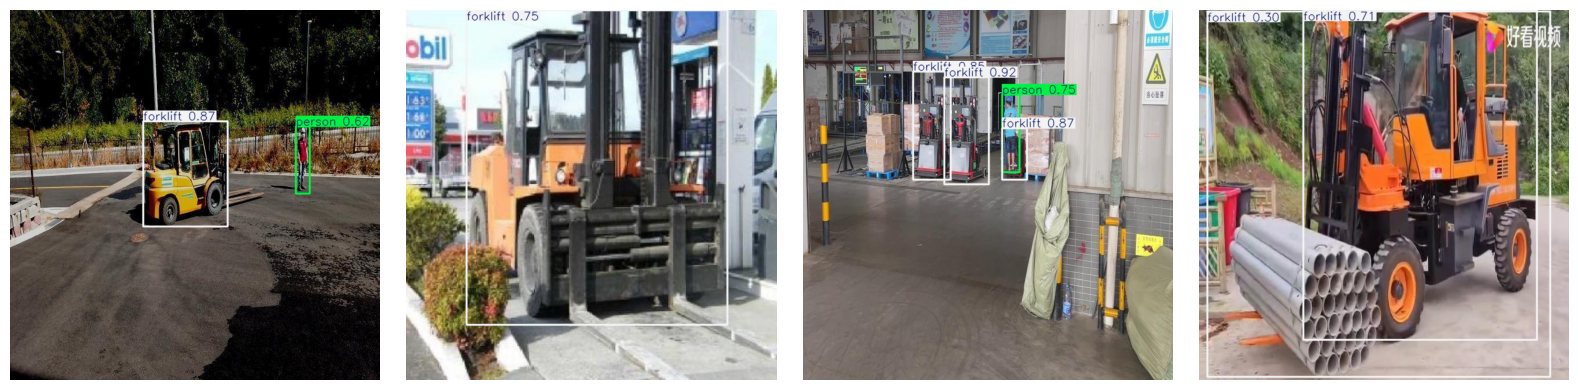

In [12]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for ax, r in zip(axes, pred):
    im = r.plot()  # numpy array con anotaciones
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Export and deploy

In [13]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target)
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


Wheight export to: artifacts/model_best.pt
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 21, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 171ms
Prepared 6 packages in 4.30s
Installed 6 packages in 912ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74

requirements: AutoUpdate success ✅ 6.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...


In [14]:
!zip -r artifacts.zip artifacts
!zip -r runs.zip runs
from google.colab import files

# Para archivos individuales
files.download('yolo11n.pt')

  adding: artifacts/ (stored 0%)
  adding: artifacts/metrics_summary.json (deflated 45%)
  adding: artifacts/model_best.pt (deflated 10%)
  adding: artifacts/classes.json (deflated 49%)
  adding: artifacts/model.onnx (deflated 13%)
  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/val_batch0_labels.jpg (deflated 7%)
  adding: runs/detect/val/val_batch2_labels.jpg (deflated 5%)
  adding: runs/detect/val/val_batch0_pred.jpg (deflated 7%)
  adding: runs/detect/val/confusion_matrix.png (deflated 18%)
  adding: runs/detect/val/BoxP_curve.png (deflated 4%)
  adding: runs/detect/val/val_batch1_labels.jpg (deflated 8%)
  adding: runs/detect/val/BoxR_curve.png (deflated 6%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 7%)
  adding: runs/detect/val/BoxPR_curve.png (deflated 8%)
  adding: runs/detect/val/confusion_matrix_normalized.png (deflated 15%)
  adding: runs/detect/val/BoxF1_curve.png (deflated 5%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. TODOs (for the candidate)
- [ ] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [ ] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [ ] Record key metrics and justify the final baseline.
- [ ] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.